<a href="https://colab.research.google.com/github/PTson2207/Food-Classification-Keras/blob/main/Food_Classification_with_Deep_Learning_in_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
#from scipy.misc import imresize

%matplotlib inline

import os
from os import listdir
from os.path import isfile, join
import shutil
import stat
import collections
from collections import defaultdict

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

import h5py
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.applications.inception_v3 import preprocess_input
from keras.models import load_model

In [2]:
!wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz

--2021-01-26 02:30:02--  http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz [following]
--2021-01-26 02:30:03--  https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4996278331 (4.7G) [application/x-gzip]
Saving to: ‘food-101.tar.gz’

food-101.tar.gz     100%[===================>]   4.65G  26.4MB/s    in 3m 1s   

2021-01-26 02:33:04 (26.3 MB/s) - ‘food-101.tar.gz’ saved [4996278331/4996278331]



In [3]:
!tar xzvf food-101.tar.gz

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
food-101/images/cannoli/695879.jpg
food-101/images/cannoli/1767088.jpg
food-101/images/cannoli/3201965.jpg
food-101/images/cannoli/3778102.jpg
food-101/images/cannoli/2674065.jpg
food-101/images/cannoli/1169899.jpg
food-101/images/cannoli/1378086.jpg
food-101/images/cannoli/803909.jpg
food-101/images/cannoli/1067240.jpg
food-101/images/cannoli/3002709.jpg
food-101/images/cannoli/2612632.jpg
food-101/images/cannoli/3627612.jpg
food-101/images/cannoli/1798703.jpg
food-101/images/cannoli/560632.jpg
food-101/images/cannoli/512468.jpg
food-101/images/cannoli/2331523.jpg
food-101/images/cannoli/3118302.jpg
food-101/images/cannoli/1499412.jpg
food-101/images/cannoli/1557459.jpg
food-101/images/cannoli/146566.jpg
food-101/images/cannoli/96922.jpg
food-101/images/cannoli/1699562.jpg
food-101/images/cannoli/730051.jpg
food-101/images/cannoli/2177977.jpg
food-101/images/cannoli/2767028.jpg
food-101/images/cannoli/6564.jpg
food-101/images/ca

In [4]:
!ls food-101/images

apple_pie	    eggs_benedict	     onion_rings
baby_back_ribs	    escargots		     oysters
baklava		    falafel		     pad_thai
beef_carpaccio	    filet_mignon	     paella
beef_tartare	    fish_and_chips	     pancakes
beet_salad	    foie_gras		     panna_cotta
beignets	    french_fries	     peking_duck
bibimbap	    french_onion_soup	     pho
bread_pudding	    french_toast	     pizza
breakfast_burrito   fried_calamari	     pork_chop
bruschetta	    fried_rice		     poutine
caesar_salad	    frozen_yogurt	     prime_rib
cannoli		    garlic_bread	     pulled_pork_sandwich
caprese_salad	    gnocchi		     ramen
carrot_cake	    greek_salad		     ravioli
ceviche		    grilled_cheese_sandwich  red_velvet_cake
cheesecake	    grilled_salmon	     risotto
cheese_plate	    guacamole		     samosa
chicken_curry	    gyoza		     sashimi
chicken_quesadilla  hamburger		     scallops
chicken_wings	    hot_and_sour_soup	     seaweed_salad
chocolate_cake	    hot_dog		     shrimp_and_grits
chocolate_mousse    huevo

In [5]:
!ls food-101/images/apple_pie/ | head -10

1005649.jpg
1011328.jpg
101251.jpg
1014775.jpg
1026328.jpg
1028787.jpg
1034399.jpg
103801.jpg
1038694.jpg
1043283.jpg


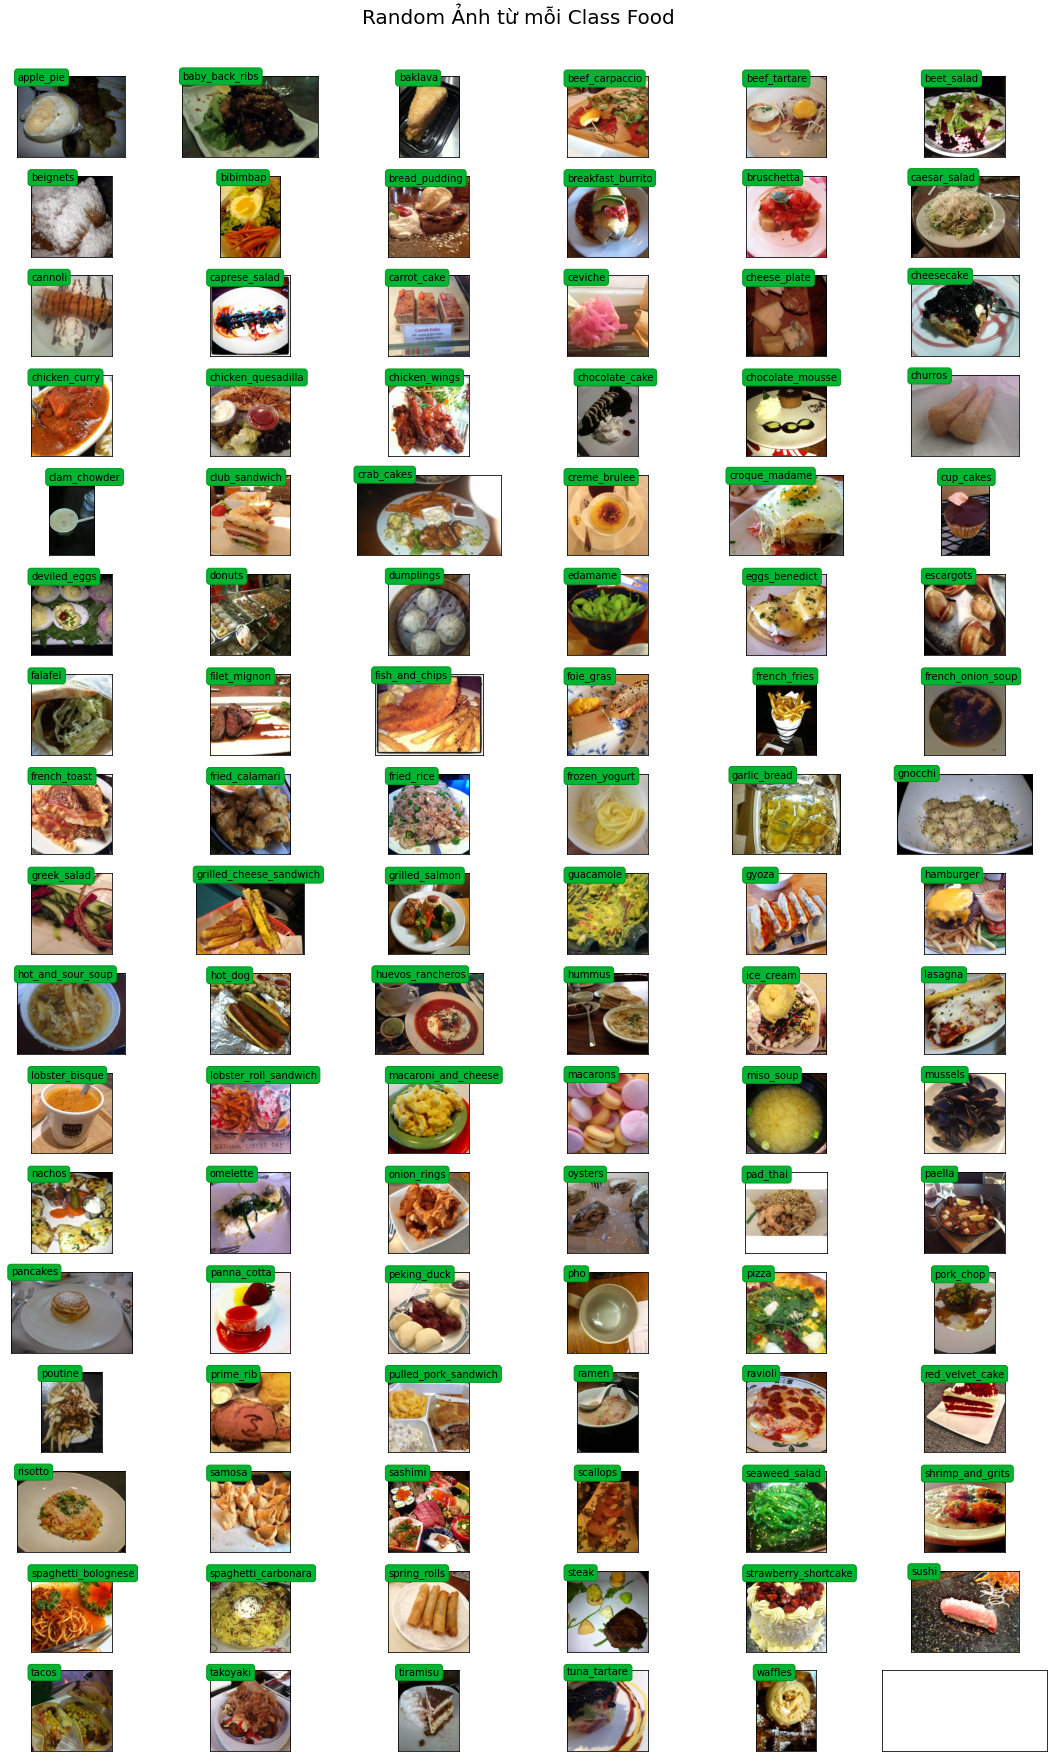

In [6]:
root_dir  = 'food-101/images/'
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, frameon=False, figsize=(15, 25))
fig.suptitle("Random Ảnh từ mỗi Class Food", fontsize=20)
sorted_food_dirs = sorted(os.listdir(root_dir))
for i in range(rows):
    for j in range(cols):
        try:
            food_dir = sorted_food_dirs[i*cols + j]
        except:
            break
        all_files = os.listdir(os.path.join(root_dir, food_dir))
        rand_img = np.random.choice(all_files)
        img = plt.imread(os.path.join(root_dir, food_dir, rand_img))
        ax[i][j].imshow(img)
        ec = (0, .6, .1)
        fc = (0, .7, .2)
        ax[i][j].text(0, -20, food_dir, size=10, rotation=0, ha="left", va="top",
                      bbox=dict(boxstyle="round", ec=ec, fc=fc))

plt.setp(ax, xticks=[], yticks=[])
plt.tight_layout(rect=[0, 0.003, 1, 0.95])

In [7]:
import multiprocessing as mp

num_processes = 6
pool = mp.Pool(processes=num_processes)

    Bản đồ từ lớp này sang chỉ muck và ngược lại, để mã hóa nhãn thích hợp và in ấn đẹp

In [8]:
class_to_ix = {}
ix_to_class = {}
with open('food-101/meta/classes.txt', 'r') as txt:
    classes = [l.strip() for l in txt.readlines()]
    class_to_ix = dict(zip(classes, range(len(classes))))
    ix_to_class = dict(zip(range(len(classes)), classes))
    ckass_to_ix = {v: k for k, v in ix_to_class.items()}
sorted_class_to_ix = collections.OrderedDict(sorted(class_to_ix.items()))

    Trong bộ dữ liệu Food-101 có sẵn train/test split. Sử dụng điều này để so sánh hiệu suất
    phân loại với các triển khai khác.

In [10]:
# chỉ split file khi chưa có 
if not os.path.isdir('./food-101/test') and not os.path.isdir('./food-101/train'):
    def copytree(src, dst, symlinks=False, ignore=None):
        if not os.path.exists(dst):
            os.makedirs(dst)
            shutil.copystat(src, dst)
        lst = os.listdir(src)
        if ignore:
            excl = ignore(src, lst)
            lst = [x for x in lst if x not in excl]
        for item in lst:
            s = os.path.join(src, item)
            d = os.path.join(dst, item)
            if symblinks and os.path.islink(s):
                if os.path.lexists(d):
                    os.remove(d)
                os.symlinks(os.readlink(s), d)
                try:
                    st = os.lstat(s)
                    mode = stat.S_IMODE(st.st_mode)
                    os.lchown(d, mode)
                except:
                    pass
            elif os.path.isdir(s):
                copytree(s, d, symlinks, ignore)
            else:
                shutil.copy2(s, d)
    
    def generate_dir_file_map(path):
        dir_files = defaultdict(list)
        with open(path, 'r') as txt:
            files = [l.strip() for l in txt.readlines()]
            for f in files:
                dir_name, id = f.split('/')
                dir_files[dir_name].append(id + 'jpg')
        return dir_files
    
    train_dir_files = generate_dir_file_map('food-101/meta/train.txt')
    test_dir_files = generate_dir_file_map('food-101/meta/test.txt')
    
    def ignore_train(d, filenames):
        print(d)
        subdir = d.split('/')[-1]
        to_ignore = train_dir_files[subdir]
        return to_ignore

    def ignore_test(d, filenames):
        print(d)
        subdir = d.split('/')[-1]
        to_ignore = test_dir_files[subdir]
        return to_ignore

    copytree('food-101/images', 'food-101/test', ignore=ignore_train)
    copytree('food-101/images', 'food-101/test', ignore=ignore_test)

else:
    print("Các tệp train/test đã copy vào các thư mục riêng biệt")

Các tệ train/test đã copy vào các thư mục riêng biệt


    Load hình ảnh lên, nếu kích thước không thích ứng thì sẽ resize

In [11]:
def load_images(root, min_side=299):
    all_imgs = []
    all_classes = []
    resize_count = 0
    invalid_count = 0
    for i, subdir in enumerate(listdir(root)):
        imgs = listdir(join(root, subdir))
        class_ix = class_to_ix[subdir]
        print(i, class_ix, subdir)
        for img_name in imgs:
            img_arr = img.imread(join(root, subdir, img_name))
            img_arr_rs = img_arr
            try:
                w, h, _ = img_arr.shape
                if w < min_side:
                    wpercent = (min/float(w))
                    hsize = int((float(h)*flaot(wpercent)))
                    img_arr_rs = imgresize(img_arr, (min_size, hsize))
                    resize_count += 1
                elif h < min_side:
                    hpercent = (min_side/float(h))
                    wsize = int((float(w)*float(hpercent)))
                    img_arr_rs = imresize(img_arr, (wsize, min_size))
                    resize_count += 1
                all_imgs.append(img_arr_rs)
                all_classes.append(class_ix)
            except:
                print("Bỏ qua hình ảnh xấu:", subdir, img_name)
                invalid_count += 1
    print(len(all_imgs), 'images loaded')
    print(resize_count, 'images resized')
    print(invalid_count, 'images skipped')
    return np.array(all_imgs), np.array(all_classes)


In [12]:
X_test, y_test = load_images('food-101/test', min_side=299)

0 images loaded
0 images resized
0 images skipped
